# Advanced Housing Dataset Exploration
1.  Introduction
2.  Exploring the Data
3.  Plotting the Data
4.  Training the Model

# Introduction


Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn, and scikit-learn to improve my data analysis and visualization skills. I know this analysis is rather simplistic and makes some arbitrary selections. But I'm primarily focusing on my competence with these libraries, not so much on the optimal data science procedures.

## Procedure

1. Split Validation Data (Test data is already seperate, Kaggle will test my model on that data)
  1. 80 / 20 Split
  2. k-fold cross validation
    1. I'll have to rerun the whole pipeline for each fold
    2. I've read that 5 or 10 folds are good. Not sure why exactly those numbers.
2. Visually investigate the data
3.  Feature Generations 
  1. Categorical Parings
  2. Numerical Transformations 
4.  Feature Selection
  1. Univariate
  2. Lasso (L1)
  3. Ridge (L2)
5.  Try different models
  1.  Simple Regression
  2.  Random Forest
  3.  XGBoost
  4.  LightGBM
  5.  Neural Net (lol wut)
6.  Hyperparameter Tuning (my fav)
7.  Compare them!

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

# pd.options.display.max_columns = None
pd.options.display.max_rows = 56

housing = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('D:/code/Data/house-prices-advanced-regression-techniques/test.csv')

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [184]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

In [185]:
# # Scatter Plots for all features vs target

# for feature in train.columns:
#     if feature != 'SalePrice':
#         plt.figure(figsize = (1, 1))
#         sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
#         plt.title(f'Sale Price vs {feature}')
#         plt.show()

In [186]:
# # Let's try to do regression only for numerical features vs target

# count = 0

# for feature in train.columns:
#     if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
#         count += 1
#         plt.figure(figsize = (1, 1))
#         plt.title(f'Sale Price vs {feature}')
#         sns.regplot(x = feature, y = 'SalePrice', data = train)
#         plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.

# Preprocessing the Data

In [187]:
display(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1314,1315,20,RL,60.0,8190,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,6,1954,1954,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,732,Unf,0,216,948,GasA,Ex,Y,SBrkr,948,0,0,948,1,0,1,0,3,1,TA,5,Typ,1,TA,Detchd,1956.0,Unf,1,280,TA,TA,Y,0,36,0,0,0,0,NaN,NaN,NaN,0,10,2007,WD,Normal,119000
1415,1416,120,RL,51.0,3635,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2007,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,130.0,Gd,TA,PConc,Gd,TA,No,ALQ,988,Unf,0,398,1386,GasA,Ex,Y,SBrkr,1569,0,0,1569,0,1,2,0,1,1,Gd,7,Typ,1,TA,Attchd,2007.0,RFn,3,660,TA,TA,Y,143,20,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,175900
1160,1161,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NPkVill,Norm,Norm,Twnhs,2Story,6,5,1978,1978,Gable,CompShg,Plywood,Brk Cmn,None,0.0,TA,TA,CBlock,Gd,TA,No,ALQ,311,Unf,0,544,855,GasA,Fa,Y,SBrkr,855,601,0,1456,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1978.0,Unf,2,440,TA,TA,Y,26,0,0,0,0,0,NaN,NaN,NaN,0,7,2010,WD,Normal,146000
1204,1205,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,5,6,1975,1975,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,No,ALQ,788,Unf,0,268,1056,GasA,Ex,Y,SBrkr,1074,0,0,1074,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1975.0,RFn,2,495,TA,TA,Y,0,88,0,0,0,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal,153500
408,409,60,RL,109.0,14154,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Ex,Gd,No,Unf,0,Unf,0,1063,1063,GasA,Ex,Y,SBrkr,1071,1101,0,2172,0,0,2,1,3,1,Gd,9,Typ,1,Gd,Attchd,2006.0,RFn,3,947,TA,TA,Y,192,62,0,0,0,0,NaN,NaN,NaN,0,8,2007,New,Partial,280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,187,80,RL,NaN,9947,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,7,5,1990,1991,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,611,Unf,0,577,1188,GasA,Ex,Y,SBrkr,1217,0,0,1217,1,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,1990.0,Unf,2,497,TA,TA,Y,168,27,0,0,0,0,NaN,GdPrv,NaN,0,6,2009,WD,Normal,173000
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,3,6,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,600,600,Grav,Fa,N,SBrkr,600,368,0,968,0,0,1,0,2,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,37900
682,683,120,RL,NaN,2887,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1Story,6,5,1996,1997,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,Gd,TA,Mn,GLQ,1003,Unf,0,288,1291,GasA,Ex,Y,SBrkr,1291,0,0,1291,1,0,1,0,2,1,Gd,6,Typ,1,Gd,Attchd,1996.0,Unf,2,431,TA,TA,Y,307,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal,173000
1091,1092,160,FV,24.0,2160,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,7,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,212.0,Gd,TA,PConc,Gd,TA,No,BLQ,510,Unf

In [188]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [189]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,968.000000,1168.000000,1168.000000,1168.000000,1168.00000,1168.000000,1162.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1105.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.00000
mean,732.239726,56.245719,70.389463,10601.309932,6.111301,5.584760,1971.47774,1984.916952,103.477625,451.458048,47.678082,568.451199,1067.587329,1172.314212,337.970034,5.506849,1515.791096,0.421233,0.059932,1.567637,0.369007,2.869007,1.047945,6.518836,0.612158,1978.557466,1.766267,475.273116,94.449486,45.498288,20.869863,3.785103,14.639555,2.261986,43.659247,6.363870,2007.808219,181359.27911
std,419.223572,41.912428,24.318002,10648.631608,1.380340,1.102932,30.10495,20.780630,179.974857,467.330819,164.026919,444.092920,443.353421,388.485969,433.408349,46.484225,522.765528,0.524264,0.244572,0.549719,0.498462,0.800042,0.221615,1.586032,0.651481,24.681717,0.746997,215.535450,126.050367,65.752503,60.116626,31.327021,55.450274,34.583206,497.104173,2.727303,1.327658,79566.97611
min,2.000000,20.000000,21.000000,1300.000000,1.000000,2.000000,1872.00000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.00000
25%,371.750000,20.000000,60.000000,7594.500000,5.000000,5.000000,1954.00000,1967.000000,0.000000,0.000000,0.000000,222.500000,800.000000,894.000000,0.000000,0.000000,1133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,327.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.00000
50%,732.500000,50.000000,70.000000,9496.000000,6.000000,5.000000,1973.00000,1993.000000,0.000000,384.000000,0.000000,470.000000,1004.000000,1095.500000,0.000000,0.000000,1456.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,161875.00000
75%,1088.250000,70.000000,80.000000,11645.000000,7.000000,6.000000,2001.00000,2004.000000,166.750000,733.000000,0.000000,811.500000,1306.750000,1414.000000,727.250000,0.000000,1774.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,577.000000,168.000000,65.250000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.00000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.00000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,576.000000,15500.000000,12.000000,2010.000000,745000.00000


## Dealing with missing values

We have a number of choices for dealing with missing values. Let's begin by dropping features which are missing a lot of data (15% or more).

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [190]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     200
Alley          1096
FireplaceQu     557
PoolQC         1163
Fence           947
MiscFeature    1123
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,LotFrontage,Alley,FireplaceQu,PoolQC,Fence,MiscFeature
1314,60.0,NaN,TA,NaN,NaN,NaN
1415,51.0,NaN,TA,NaN,NaN,NaN
1160,24.0,NaN,TA,NaN,NaN,NaN
1204,78.0,NaN,NaN,NaN,MnPrv,NaN
408,109.0,NaN,Gd,NaN,NaN,NaN
...,...,...,...,...,...,...
186,NaN,NaN,NaN,NaN,GdPrv,NaN
968,50.0,NaN,NaN,NaN,GdWo,NaN
682,NaN,NaN,Gd,NaN,NaN,NaN
1091,24.0,Pave,NaN,NaN,NaN,NaN


All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [191]:
columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1314,1315,20,RL,8190,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,6,1954,1954,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,732,Unf,0,216,948,GasA,Ex,Y,SBrkr,948,0,0,948,1,0,1,0,3,1,TA,5,Typ,1,Detchd,1956.0,Unf,1,280,TA,TA,Y,0,36,0,0,0,0,0,10,2007,WD,Normal,119000
1415,1416,120,RL,3635,Pave,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2007,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,130.0,Gd,TA,PConc,Gd,TA,No,ALQ,988,Unf,0,398,1386,GasA,Ex,Y,SBrkr,1569,0,0,1569,0,1,2,0,1,1,Gd,7,Typ,1,Attchd,2007.0,RFn,3,660,TA,TA,Y,143,20,0,0,0,0,0,5,2009,WD,Normal,175900
1160,1161,160,RL,2280,Pave,Reg,Lvl,AllPub,Inside,Gtl,NPkVill,Norm,Norm,Twnhs,2Story,6,5,1978,1978,Gable,CompShg,Plywood,Brk Cmn,None,0.0,TA,TA,CBlock,Gd,TA,No,ALQ,311,Unf,0,544,855,GasA,Fa,Y,SBrkr,855,601,0,1456,0,0,2,1,3,1,TA,7,Typ,1,Attchd,1978.0,Unf,2,440,TA,TA,Y,26,0,0,0,0,0,0,7,2010,WD,Normal,146000
1204,1205,20,RL,10140,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,5,6,1975,1975,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,No,ALQ,788,Unf,0,268,1056,GasA,Ex,Y,SBrkr,1074,0,0,1074,1,0,1,1,3,1,TA,6,Typ,0,Attchd,1975.0,RFn,2,495,TA,TA,Y,0,88,0,0,0,0,0,7,2006,WD,Normal,153500
408,409,60,RL,14154,Pave,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Ex,Gd,No,Unf,0,Unf,0,1063,1063,GasA,Ex,Y,SBrkr,1071,1101,0,2172,0,0,2,1,3,1,Gd,9,Typ,1,Attchd,2006.0,RFn,3,947,TA,TA,Y,192,62,0,0,0,0,0,8,2007,New,Partial,280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,187,80,RL,9947,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,7,5,1990,1991,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,611,Unf,0,577,1188,GasA,Ex,Y,SBrkr,1217,0,0,1217,1,0,2,0,3,1,Gd,6,Typ,0,Attchd,1990.0,Unf,2,497,TA,TA,Y,168,27,0,0,0,0,0,6,2009,WD,Normal,173000
968,969,50,RM,5925,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,3,6,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,600,600,Grav,Fa,N,SBrkr,600,368,0,968,0,0,1,0,2,1,TA,6,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,0,5,2009,WD,Abnorml,37900
682,683,120,RL,2887,Pave,Reg,HLS,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1Story,6,5,1996,1997,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,Gd,TA,Mn,GLQ,1003,Unf,0,288,1291,GasA,Ex,Y,SBrkr,1291,0,0,1291,1,0,1,0,2,1,Gd,6,Typ,1,Attchd,1996.0,Unf,2,431,TA,TA,Y,307,0,0,0,0,0,0,11,2008,WD,Normal,173000
1091,1092,160,FV,2160,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,7,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,212.0,Gd,TA,PConc,Gd,TA,No,BLQ,510,Unf,0,90,600,GasA,Ex,Y,SBrkr,624,628,0,1252,1,0,2,1,2,1,Gd,4,Typ,0,Detchd,1999.0,Unf,2,462,TA,TA,Y,0,48,0,0,0,0,0,3,2008,WD,Normal,160000


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
439,440,50,RL,12354,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,8,1920,2000,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Unf,0,Unf,0,684,684,GasA,Gd,Y,SBrkr,684,512,0,1196,0,0,1,0,3,1,Gd,7,Typ,0,Detchd,2005.0,Unf,2,528,TA,TA,Y,0,46,0,0,0,0,800,8,2009,ConLI,Normal,110000
1107,1108,60,RL,23257,Pave,IR3,HLS,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,Gd,No,Unf,0,Unf,0,868,868,GasA,Ex,Y,SBrkr,887,1134,0,2021,0,0,2,1,3,1,Gd,9,Typ,1,BuiltIn,2006.0,RFn,2,422,TA,TA,Y,0,100,0,0,0,0,0,9,2006,New,Partial,274725
462,463,20,RL,8281,Pave,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1965,1965,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,553,BLQ,311,0,864,GasA,Gd,Y,SBrkr,864,0,0,864,0,0,1,0,3,1,TA,5,Typ,1,Detchd,1965.0,Unf,1,360,TA,TA,Y,0,0,236,0,0,0,0,12,2009,WD,Normal,62383
867,868,20,RL,6970,Pave,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,4,5,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,932,Unf,0,108,1040,GasA,TA,Y,SBrkr,1120,0,0,1120,1,0,1,1,3,1,Fa,5,Typ,0,Attchd,1961.0,RFn,2,544,TA,TA,Y,168,0,0,0,0,0,400,5,2007,WD,Normal,129000
774,775,20,RL,14226,Pave,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,375.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1935,1935,GasA,Gd,Y,SBrkr,1973,0,0,1973,0,0,2,0,3,1,Gd,9,Typ,1,Attchd,2006.0,Fin,3,895,TA,TA,Y,315,45,0,0,0,0,0,7,2007,New,Partial,395000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,1307,120,RL,6955,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,94.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1368,1368,GasA,Ex,Y,SBrkr,1368,0,0,1368,0,0,2,0,2,1,Gd,6,Typ,1,Attchd,2005.0,RFn,2,474,TA,TA,Y,132,35,0,0,0,0,0,9,2006,New,Partial,202500
362,363,85,RL,7301,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,SFoyer,7,5,2003,2003,Gable,CompShg,HdBoard,HdBoard,BrkFace,500.0,Gd,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Ex,Y,SBrkr,495,1427,0,1922,0,0,3,0,4,1,Gd,7,Typ,1,BuiltIn,2003.0,RFn,2,672,TA,TA,Y,0,0,177,0,0,0,0,7,2009,ConLD,Normal,198500
846,847,60,RL,9317,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1993,1993,Gable,CompShg,HdBoard,HdBoard,BrkFace,137.0,Gd,TA,PConc,Gd,TA,No,ALQ,513,Unf,0,227,740,GasA,Ex,Y,SBrkr,1006,769,0,1775,1,0,2,1,3,1,Gd,7,Typ,1,Attchd,1993.0,Unf,2,425,TA,TA,Y,234,72,192,0,0,0,0,7,2009,WD,Normal,213000
1206,1207,20,RH,8900,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,4,4,1966,1966,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,1056,Unf,0,0,1056,GasA,TA,Y,SBrkr,1056,0,0,1056,1,0,1,0,2,1,TA,5,Typ,0,Detchd,1966.0,Unf,1,384,TA,TA,Y,0,42,0,0,0,0,0,11,2006,WD,Normal,107000


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


That was a good start, but we still have a lot of missing values throughout our data. Let's do simple imputting for the rest, with median for numerical features and mode for categorical features. sklearn has a great function for this built in.

In [192]:
num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

display(num_columns)
display(cat_columns)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [193]:
# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [194]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
1314,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Normal
1415,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,Hip,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1160,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NPkVill,Norm,Norm,Twnhs,2Story,Gable,CompShg,Plywood,Brk Cmn,None,TA,TA,CBlock,Gd,TA,No,ALQ,Unf,GasA,Fa,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1204,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,CBlock,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
408,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Ex,Gd,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,New,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
968,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,Grav,Fa,N,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Abnorml
682,RL,Pave,Reg,HLS,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1091,FV,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,Gd,TA,PConc,Gd,TA,No,BLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Normal


Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of features that seem ordinal to me:
1.  LotShape: How regular or irregular the property is shaped
2. Utilities: Which utilities are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. Electrical: Electrical system
14. KitchenQual: Kitchen quality
15. Functional: Home functionality (Assume typical unless deductions are warranted)
16. FireplaceQu: Fireplace quality. BUT we already dropped this, as it was missing too many values.
17. GarageFinish: Interior finish of the garage
18. GarageQual: Garage quality
19. GarageCond: Garage condition
20. PavedDrive: Paved driveway
21. PoolQC: Pool quality. But, we already dropped this, as it was missing too many values.
22. Fence Quality. BUT, we already dropped this, as it was missing too many values.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [195]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}

# BSMTFinType1 is a bit strange, because they throw Rec Room in with all the other assesments. I'll set the two averages equal in value, then scale the rest
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map

heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}

# Electrical is also weird, as there is a mixed option. I'll just set that to a middle value.
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}

kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]

# Here's our list of columns to map, so we can just iterate through them

ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

In [196]:
for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

display(train[ordinal_features])
display(valid[ordinal_features])
display(test[ordinal_features])

C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\evant\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
1314,3.0,3,2,2,2,3,3,1,4,1,4,1,3.0,2,7,1,3,3,2
1415,3.0,3,2,3,2,4,3,1,4,1,4,1,3.0,3,7,2,3,3,2
1160,3.0,3,2,2,2,4,3,1,4,1,1,1,3.0,2,7,1,3,3,2
1204,3.0,3,2,2,2,4,3,1,4,1,4,1,3.0,2,7,2,3,3,2
408,3.0,3,2,3,2,5,4,1,1,1,4,1,3.0,3,7,2,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,2.0,3,2,2,2,4,3,3,5,1,4,1,3.0,3,7,1,3,3,2
968,3.0,3,2,2,2,3,3,1,1,1,1,0,3.0,2,7,1,3,3,2
682,3.0,3,2,2,2,4,3,2,5,1,4,1,3.0,3,7,1,3,3,2
1091,3.0,3,2,3,2,4,3,1,3,1,4,1,3.0,3,7,1,3,3,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
439,3.0,3,2,2,2,3,2,2,1,1,3,1,3,3,7,1,3,3,2
1107,NaN,3,2,3,2,5,4,1,1,1,4,1,3,3,7,2,3,3,2
462,2.0,3,2,2,2,3,3,1,4,3,3,1,3,2,7,1,3,3,2
867,3.0,3,2,2,2,3,3,1,4,1,2,1,3,1,7,2,3,3,2
774,3.0,3,2,3,2,4,3,3,1,1,3,1,3,3,7,3,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2.0,3,2,3,2,4,3,1,1,1,4,1,3,3,7,2,3,3,2
362,3.0,3,2,3,2,4,3,1,5,1,4,1,3,3,7,2,3,3,2
846,3.0,3,2,3,2,4,3,1,4,1,4,1,3,3,7,1,3,3,2
1206,3.0,3,2,2,2,3,3,1,4,1,2,1,3,2,7,1,3,3,2


,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
0,3.0,3,2,2,2,3,3,1,4,2,2,1,3,2,7,1,3,3,2
1,2.0,3,2,2,2,3,3,1,4,1,2,1,3,3,7,1,3,3,2
2,2.0,3,2,2,2,4,3,1,5,1,3,1,3,2,7,3,3,3,2
3,2.0,3,2,2,2,3,3,1,5,1,4,1,3,3,7,3,3,3,2
4,2.0,3,2,3,2,4,3,1,4,1,4,1,3,3,7,2,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3.0,3,2,2,2,3,3,1,1,1,3,1,3,2,7,1,3,3,2
1455,3.0,3,2,2,2,3,3,1,4,1,2,1,3,2,7,1,3,3,2
1456,3.0,3,2,2,2,3,3,1,4,1,4,1,3,2,7,1,3,3,2
1457,3.0,3,2,2,2,4,3,3,5,1,2,1,3,2,7,1,3,3,2


Ok, let's see what categorical features are left to deal with.

In [197]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

,MSZoning,Street,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,GarageType,SaleType,SaleCondition
1314,RL,Pave,Lvl,Inside,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,None,CBlock,GasA,Detchd,WD,Normal
1415,RL,Pave,Lvl,Inside,Blmngtn,Norm,Norm,TwnhsE,1Story,Hip,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,WD,Normal
1160,RL,Pave,Lvl,Inside,NPkVill,Norm,Norm,Twnhs,2Story,Gable,CompShg,Plywood,Brk Cmn,None,CBlock,GasA,Attchd,WD,Normal
1204,RL,Pave,Lvl,Inside,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,CBlock,GasA,Attchd,WD,Normal
408,RL,Pave,Lvl,Corner,NridgHt,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Attchd,New,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,RL,Pave,Lvl,CulDSac,Mitchel,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,None,PConc,GasA,Attchd,WD,Normal
968,RM,Pave,Lvl,Inside,OldTown,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,None,BrkTil,Grav,Attchd,WD,Abnorml
682,RL,Pave,HLS,Inside,ClearCr,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,PConc,GasA,Attchd,WD,Normal
1091,FV,Pave,Lvl,Inside,Somerst,Norm,Norm,Twnhs,2Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,PConc,GasA,Detchd,WD,Normal


Honestly, I'm not sure what to do with these features for right now, so let's DROP EM ALL!!!! HAHAHAHAHAHAHAHAHA.

One-Hot would be my next choice, but who has time for that???

In [198]:
cat_columns = train.select_dtypes(include=['object']).columns

display(cat_columns)

train.drop(cat_columns, inplace = True, axis = 1)
valid.drop(cat_columns, inplace = True, axis = 1)
test.drop(cat_columns, inplace = True, axis = 1)

Index(['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

C:\Users\evant\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Numerical Features

Let's consider the correlation coefficients for each pair of Numerical Features.

,Id,MSSubClass,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.019947,-0.044133,0.042209,-0.014863,0.012884,-0.029872,0.019400,-0.017897,-0.017085,-0.059294,-0.014937,0.021595,-0.031339,0.009576,0.015313,-0.012998,0.002957,-0.021106,-0.025153,-0.015240,-0.021454,-0.006501,0.014465,0.071277,0.005316,0.007780,-0.034432,0.007339,-0.005201,-0.031147,0.016178,0.011608,0.047581,-0.005215,0.003372,0.027360,0.001775,-0.018547,0.002809,0.023761,0.010071,0.018559,0.008386,-0.009881,0.013659,-0.026025,-0.010980,-0.011146,-0.046273,0.019319,0.049720,-0.021517,0.002547,-0.008283,-0.025887
MSSubClass,0.019947,1.000000,-0.113676,0.094216,0.025326,0.017320,0.023744,-0.069714,0.018706,0.040383,0.023747,0.014256,-0.056554,0.074440,-0.001199,0.045811,-0.002772,-0.071055,-0.058166,-0.086406,-0.138344,-0.245440,-0.041044,-0.122654,0.024572,-0.242563,0.315738,0.023435,0.083594,-0.002843,0.007340,0.141108,0.171984,-0.005096,0.287856,-0.014827,0.045634,-0.025713,-0.033130,0.081924,-0.001454,-0.029420,-0.087210,0.047821,-0.002783,-0.071615,0.009416,0.002708,-0.007554,-0.056637,-0.025524,0.017215,-0.017924,-0.025334,-0.036434,-0.084939
LotArea,-0.044133,-0.113676,1.000000,-0.293423,-0.010378,-0.445175,0.113468,-0.003396,0.013876,0.012571,0.108556,0.055155,0.009777,0.080902,0.025884,0.235370,0.071043,0.224469,0.115442,0.123090,-0.015657,0.266465,0.000418,0.047119,0.045290,0.299289,0.039892,0.004346,0.255873,0.181874,0.039614,0.118066,0.005343,0.096304,-0.018960,0.069935,0.174046,-0.013282,0.260163,-0.019007,0.112282,0.148473,0.179911,0.040448,0.012537,0.031891,0.161282,0.064692,-0.013397,0.023099,0.033036,0.090041,0.032785,0.007446,-0.011945,0.260904
LotShape,0.042209,0.094216,-0.293423,1.000000,0.027454,0.167410,-0.210203,0.005239,-0.227690,-0.192474,-0.107856,-0.199788,-0.026608,-0.222175,-0.116064,-0.174709,-0.106603,-0.123808,-0.040846,-0.040264,-0.031519,-0.179917,-0.124071,-0.108121,-0.102408,-0.192070,-0.056716,-0.004857,-0.189736,-0.052221,-0.063651,-0.168857,-0.094462,-0.027715,0.096752,-0.198796,-0.112228,-0.025311,-0.160314,-0.209507,-0.221046,-0.201051,-0.178329,-0.130399,-0.077908,-0.118030,-0.158277,-0.081740,0.090659,-0.045475,-0.075038,-0.008280,-0.022347,-0.007017,0.031256,-0.286186
Utilities,-0.014863,0.025326,-0.010378,0.027454,1.000000,-0.006517,0.002361,-0.011026,0.013111,0.037933,-0.071377,0.020248,0.007253,0.024761,0.001546,0.018710,-0.033674,0.021335,-0.100317,-0.054691,0.014142,0.016420,0.004187,-0.007723,0.069042,-0.012942,0.022837,0.003469,0.009624,0.023530,-0.112565,0.030240,0.021680,-0.004795,0.006336,-0.021633,-0.008884,-0.007138,-0.017434,0.025078,-0.008296,-0.009163,-0.006757,-0.003014,-0.002956,-0.008329,0.021944,-0.032291,0.010167,0.003538,-0.115324,0.001915,0.002572,0.057596,-0.026288,0.016143
LandSlope,0.012884,0.017320,-0.445175,0.167410,-0.006517,1.000000,0.035885,-0.041779,0.064565,0.034238,0.017651,0.068398,0.028580,0.000814,-0.066760,-0.251727,-0.057633,-0.113711,-0.088693,-0.105399,0.116885,-0.041775,0.051090,0.003950,0.003353,-0.073645,0.001512,-0.027116,-0.055886,-0.110161,-0.084546,0.027402,0.003528,0.060192,0.048182,0.023428,0.033849,0.076011,-0.137331,0.067505,0.017406,0.000709,-0.012447,-0.036197,0.006695,0.012773,-0.117264,0.058045,0.000393,-0.013870,-0.045070,0.014567,0.001801,-0.014519,0.009766,-0.074135
OverallQual,-0.029872,0.023744,0.113468,-0.210203,0.002361,0.035885,1.000000,-0.115958,0.566079,0.544048,0.415248,0.732131,0.012017,0.676979,0.144311,0.285403,0

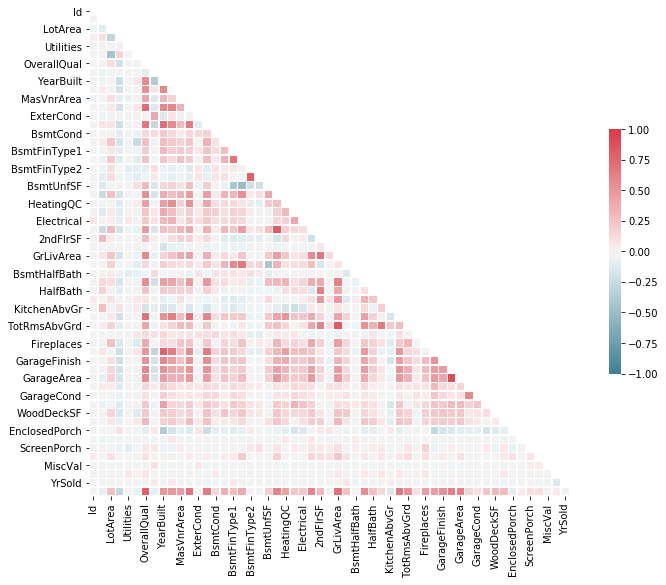

In [199]:
corr = train.corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.  

Yes, this is a gross simplification. But we'll do multivariate analysis later. I promise!!

In [200]:
display(corr['SalePrice'].sort_values())

LotShape        -0.286186
KitchenAbvGr    -0.142082
EnclosedPorch   -0.106580
MSSubClass      -0.084939
OverallCond     -0.081376
LandSlope       -0.074135
BsmtHalfBath    -0.036865
BsmtFinType2    -0.030881
Id              -0.025887
MiscVal         -0.025443
LowQualFinSF    -0.016368
BsmtFinSF2      -0.006416
YrSold          -0.001639
ExterCond        0.010512
Utilities        0.016143
3SsnPorch        0.045770
MoSold           0.051136
GarageCond       0.103311
Functional       0.110092
PoolArea         0.112011
ScreenPorch      0.115726
BsmtCond         0.142852
BedroomAbvGr     0.149746
GarageQual       0.166706
BsmtUnfSF        0.193946
Electrical       0.227095
PavedDrive       0.237464
CentralAir       0.239689
BsmtFullBath     0.259438
LotArea          0.260904
HalfBath         0.273715
BsmtFinType1     0.289466
OpenPorchSF      0.307772
WoodDeckSF       0.312191
2ndFlrSF         0.312385
BsmtExposure     0.367267
BsmtFinSF1       0.392400
HeatingQC        0.430437
Fireplaces  

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 14 numerical features.

In [201]:
corr_sp = corr['SalePrice']
display(corr_sp)

print('')
columns_to_drop2 = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop2)

train.drop(columns_to_drop2, inplace = True, axis = 1)
valid.drop(columns_to_drop2, inplace = True, axis = 1)
test.drop(columns_to_drop2, inplace = True, axis = 1)

display(train)
display(valid)
display(test)

Id              -0.025887
MSSubClass      -0.084939
LotArea          0.260904
LotShape        -0.286186
Utilities        0.016143
LandSlope       -0.074135
OverallQual      0.794749
OverallCond     -0.081376
YearBuilt        0.513790
YearRemodAdd     0.502163
MasVnrArea       0.466175
ExterQual        0.681432
ExterCond        0.010512
BsmtQual         0.649683
BsmtCond         0.142852
BsmtExposure     0.367267
BsmtFinType1     0.289466
BsmtFinSF1       0.392400
BsmtFinType2    -0.030881
BsmtFinSF2      -0.006416
BsmtUnfSF        0.193946
TotalBsmtSF      0.605517
HeatingQC        0.430437
CentralAir       0.239689
Electrical       0.227095
1stFlrSF         0.594115
2ndFlrSF         0.312385
LowQualFinSF    -0.016368
GrLivArea        0.699042
BsmtFullBath     0.259438
BsmtHalfBath    -0.036865
FullBath         0.549616
HalfBath         0.273715
BedroomAbvGr     0.149746
KitchenAbvGr    -0.142082
KitchenQual      0.670820
TotRmsAbvGrd     0.534999
Functional       0.110092
Fireplaces  

Index(['Id', 'MSSubClass', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallCond', 'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'HeatingQC', 'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Functional', 'Fireplaces', 'GarageYrBlt', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea,SalePrice
1314,4.0,1954.0,1954.0,2,3,948.0,948.0,948.0,1.0,2,5.0,1,1.0,280.0,119000.0
1415,7.0,2007.0,2007.0,3,4,1386.0,1569.0,1569.0,2.0,3,7.0,2,3.0,660.0,175900.0
1160,6.0,1978.0,1978.0,2,4,855.0,855.0,1456.0,2.0,2,7.0,1,2.0,440.0,146000.0
1204,5.0,1975.0,1975.0,2,4,1056.0,1074.0,1074.0,1.0,2,6.0,2,2.0,495.0,153500.0
408,7.0,2006.0,2006.0,3,5,1063.0,1071.0,2172.0,2.0,3,9.0,2,3.0,947.0,280000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,7.0,1990.0,1991.0,2,4,1188.0,1217.0,1217.0,2.0,3,6.0,1,2.0,497.0,173000.0
968,3.0,1910.0,1950.0,2,3,600.0,600.0,968.0,1.0,2,6.0,1,0.0,0.0,37900.0
682,6.0,1996.0,1997.0,2,4,1291.0,1291.0,1291.0,1.0,3,6.0,1,2.0,431.0,173000.0
1091,7.0,1999.0,2000.0,3,4,600.0,624.0,1252.0,2.0,3,4.0,1,2.0,462.0,160000.0


,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea,SalePrice
439,6.0,1920.0,2000.0,2,3,684.0,684.0,1196.0,1.0,3,7.0,1,2.0,528.0,110000.0
1107,7.0,2006.0,2006.0,3,5,868.0,887.0,2021.0,2.0,3,9.0,2,2.0,422.0,274725.0
462,5.0,1965.0,1965.0,2,3,864.0,864.0,864.0,1.0,2,5.0,1,1.0,360.0,62383.0
867,4.0,1961.0,1961.0,2,3,1040.0,1120.0,1120.0,1.0,1,5.0,2,2.0,544.0,129000.0
774,8.0,2006.0,2006.0,3,4,1935.0,1973.0,1973.0,2.0,3,9.0,3,3.0,895.0,395000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,7.0,2005.0,2006.0,3,4,1368.0,1368.0,1368.0,2.0,3,6.0,2,2.0,474.0,202500.0
362,7.0,2003.0,2003.0,3,4,0.0,495.0,1922.0,3.0,3,7.0,2,2.0,672.0,198500.0
846,7.0,1993.0,1993.0,3,4,740.0,1006.0,1775.0,2.0,3,7.0,1,2.0,425.0,213000.0
1206,4.0,1966.0,1966.0,2,3,1056.0,1056.0,1056.0,1.0,2,5.0,1,1.0,384.0,107000.0


,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageFinish,GarageCars,GarageArea
0,5.0,1961.0,1961.0,2,3,882.0,896.0,896.0,1.0,2,5.0,1,1.0,730.0
1,6.0,1958.0,1958.0,2,3,1329.0,1329.0,1329.0,1.0,3,6.0,1,1.0,312.0
2,5.0,1997.0,1998.0,2,4,928.0,928.0,1629.0,2.0,2,6.0,3,2.0,482.0
3,6.0,1998.0,1998.0,2,3,926.0,926.0,1604.0,2.0,3,7.0,3,2.0,470.0
4,8.0,1992.0,1992.0,3,4,1280.0,1280.0,1280.0,2.0,3,5.0,2,2.0,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.0,1970.0,1970.0,2,3,546.0,546.0,1092.0,1.0,2,5.0,1,0.0,0.0
1455,4.0,1970.0,1970.0,2,3,546.0,546.0,1092.0,1.0,2,6.0,1,1.0,286.0
1456,5.0,1960.0,1996.0,2,3,1224.0,1224.0,1224.0,1.0,2,7.0,1,2.0,576.0
1457,5.0,1992.0,1992.0,2,4,912.0,970.0,970.0,1.0,2,6.0,1,0.0,0.0


Now, we need to do some feature scaling!! Normalize this stuff.  

Eh, I'll come back to this later.

# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models. We'll start with decision tree, random forest, XGBoost, and LightGBM.

## Decision Tree

# Assessing our Results

Now that we've finished training one model from beginning to end, let's test it by uploading our results to Kaggle and see how we did.

# Developing a Pipeline

We went through a lot of steps to prepare our data and train our model. Let's condense as much of that as possible into a single pipeline that we can use for future datasets.

# Developing More Pipelines

This pipeline did ok, but surely we can do better if we tweak some of our steps. Let's develop some more pipelines from beginning to end, and compare the results of each.

# Comparing Models